## Predicting Customer Churn/Default

In [1]:
#importing libraries
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report
#suppressing unnecessary warnings while executing some code  
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

### Importing data

In [3]:
#importing data into pandas dataframe
df = pd.read_csv(r"./data/bank_data.csv")

#convert attrition flag to chirn
df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1) 

#dropping redundant columns
df.drop(columns = ['Unnamed: 0', 'CLIENTNUM', 'Attrition_Flag'], inplace=True)

df.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0
4,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0


In [4]:
df.shape #checking shape of dataframe

(10127, 20)

In [5]:
df.isnull().sum() #checking missing values

Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
Churn                       0
dtype: int64

In [6]:
df.describe() #statistical summary

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.160660
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.367235
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,1.000000


### EDA

Text(0.5, 1.0, 'Churn Histogram')

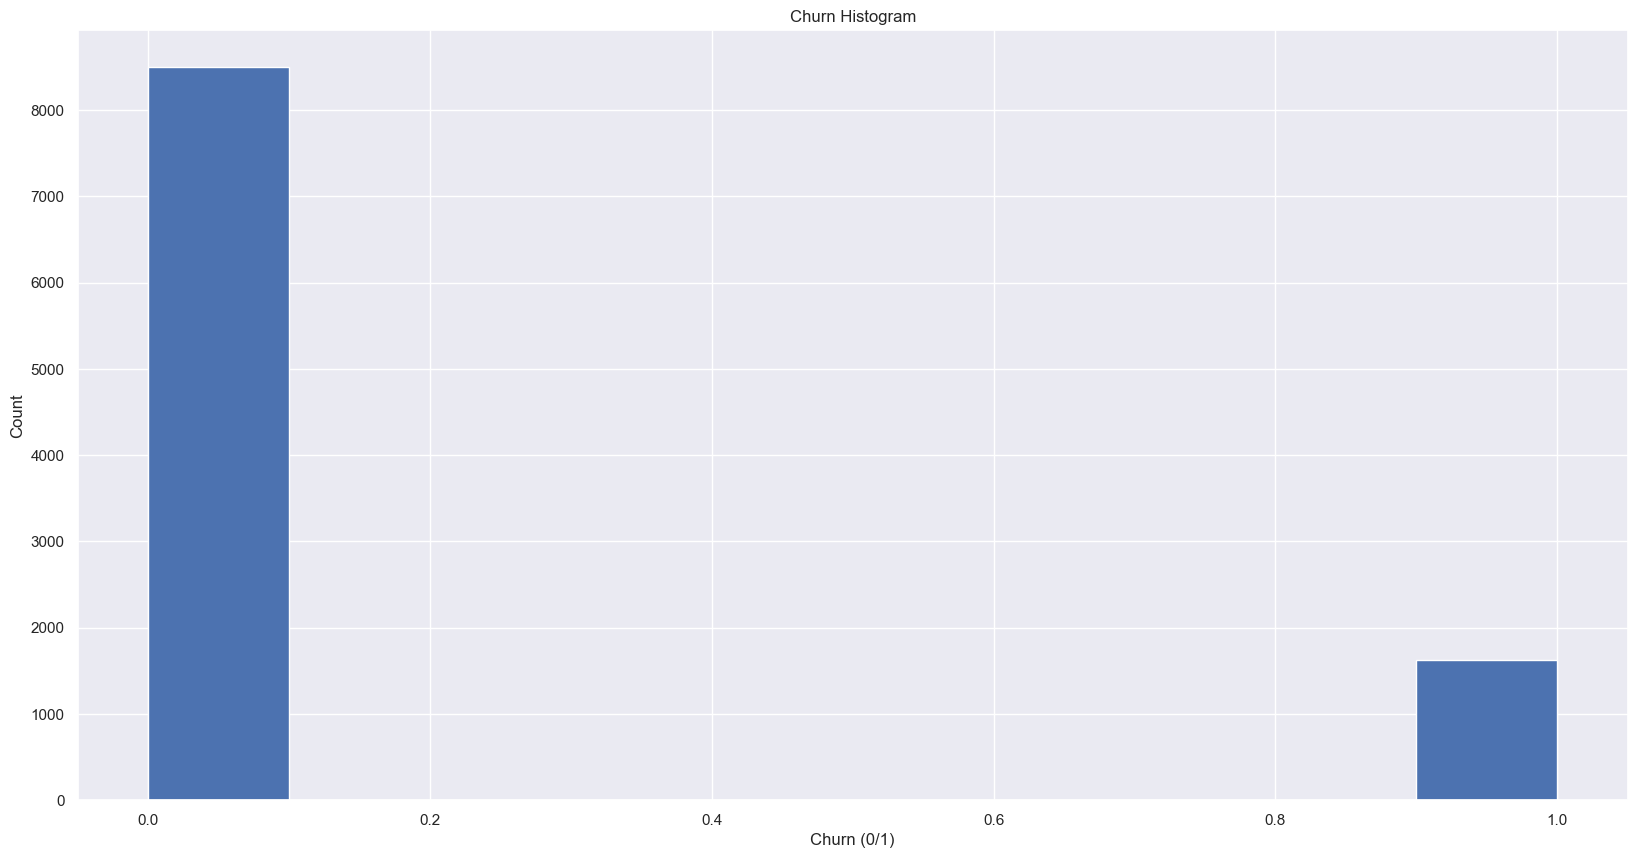

In [7]:
#Churn barplot
plt.figure(figsize=(20,10)) 
df['Churn'].hist();
plt.xlabel('Churn (0/1)');
plt.ylabel('Count');
plt.title('Churn Histogram')

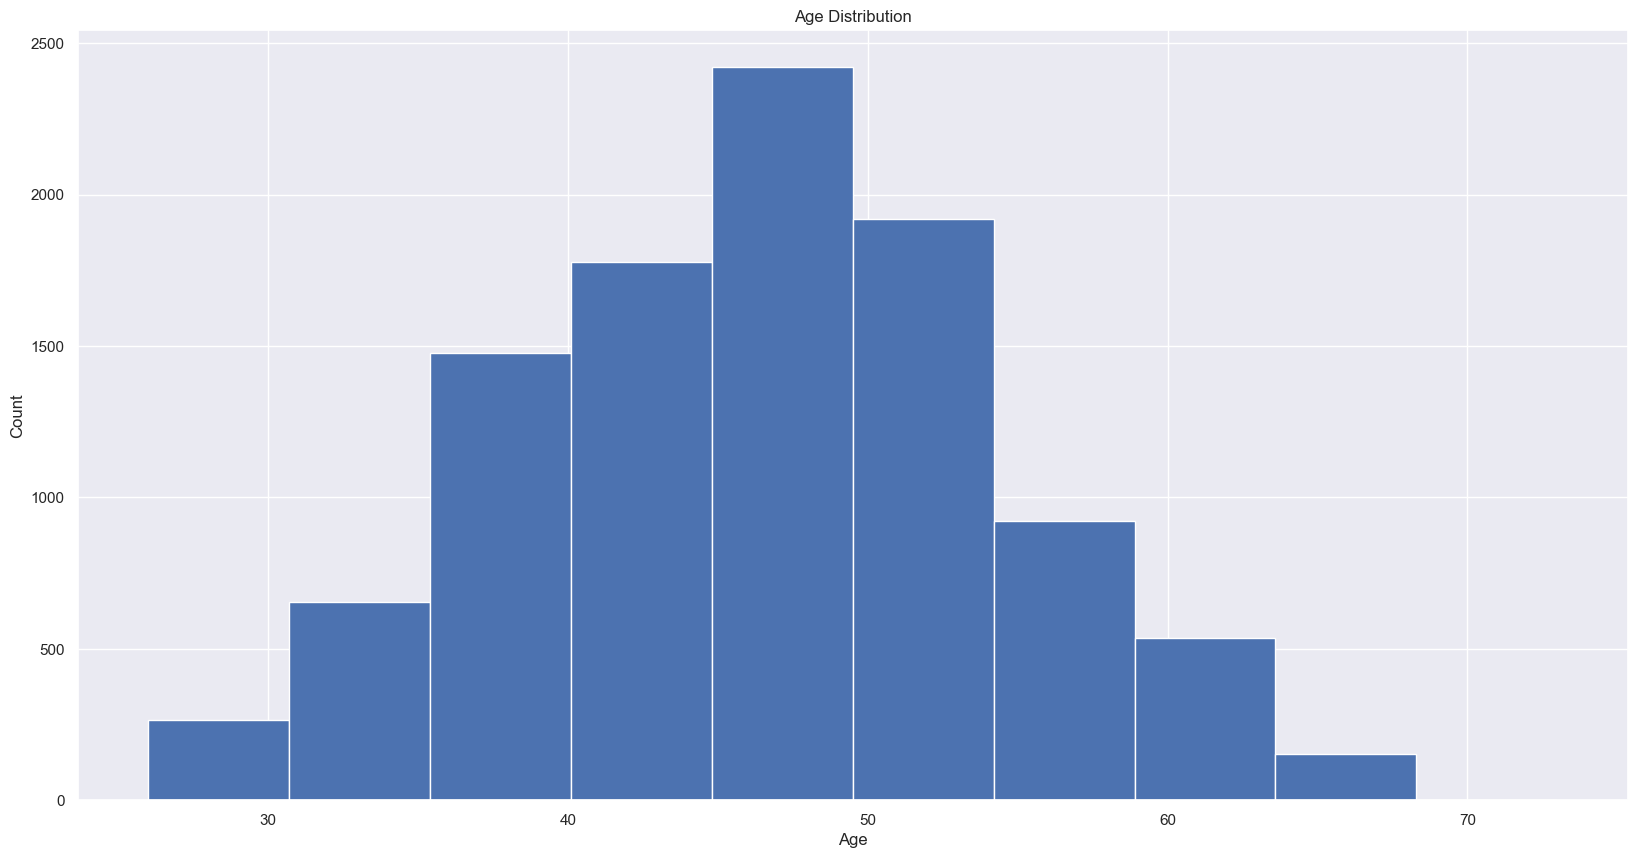

In [8]:
#age distribution
plt.figure(figsize=(20,10)) 
df['Customer_Age'].hist();
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Age Distribution');

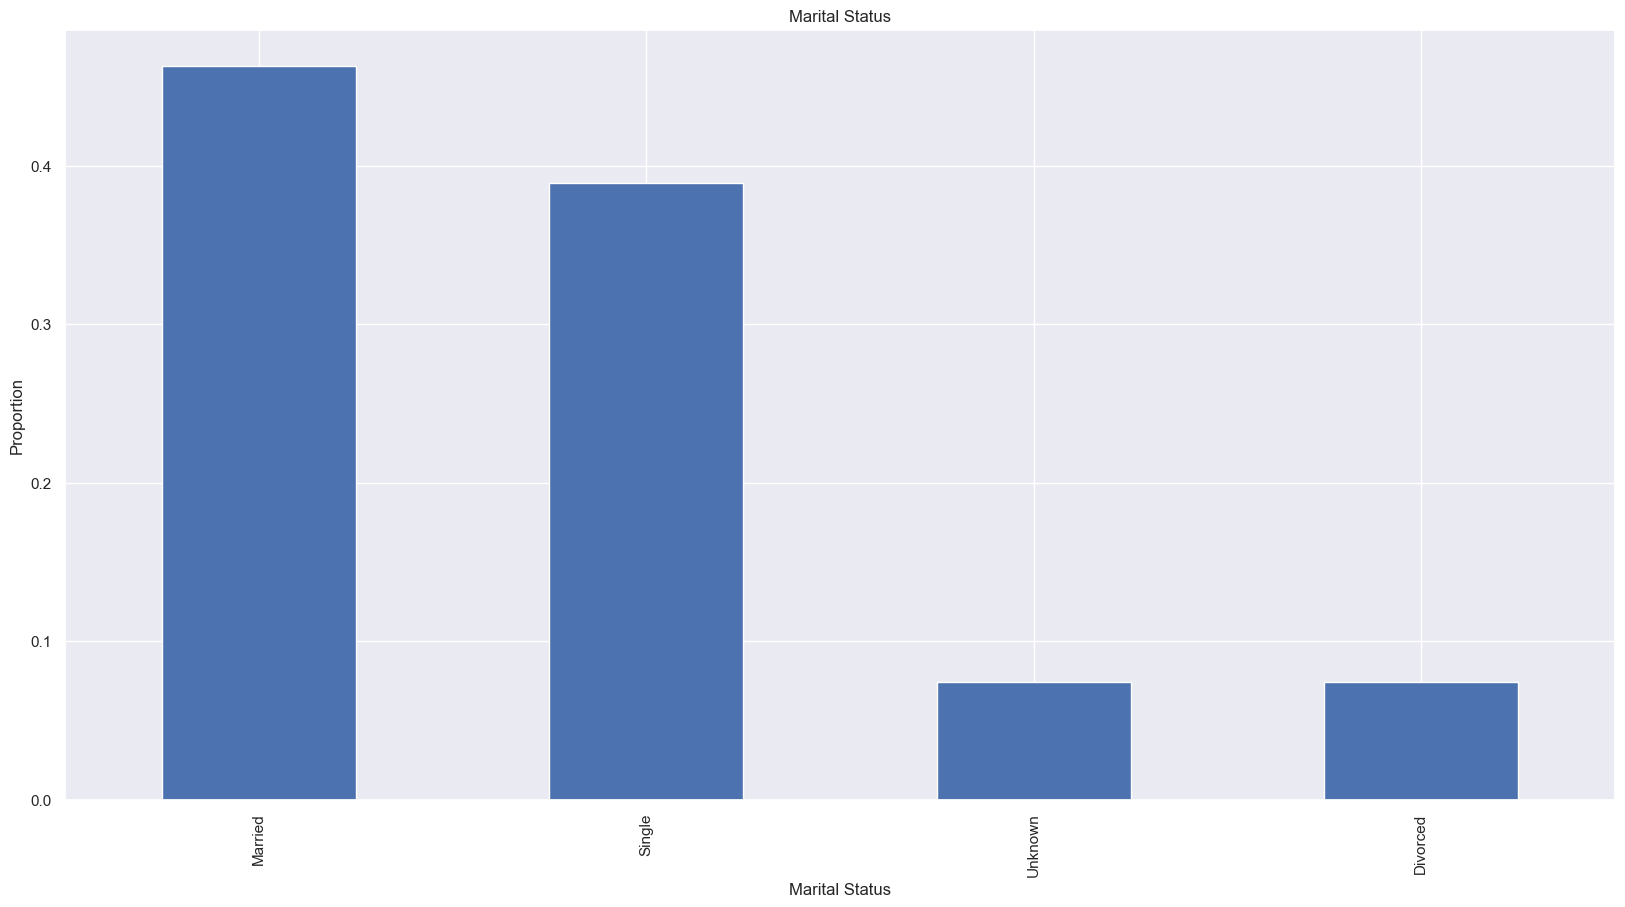

In [9]:
#marital status barplot
plt.figure(figsize=(20,10)) 
df.Marital_Status.value_counts('normalize').plot(kind='bar');
plt.xlabel('Marital Status');
plt.ylabel('Proportion');
plt.title('Marital Status');

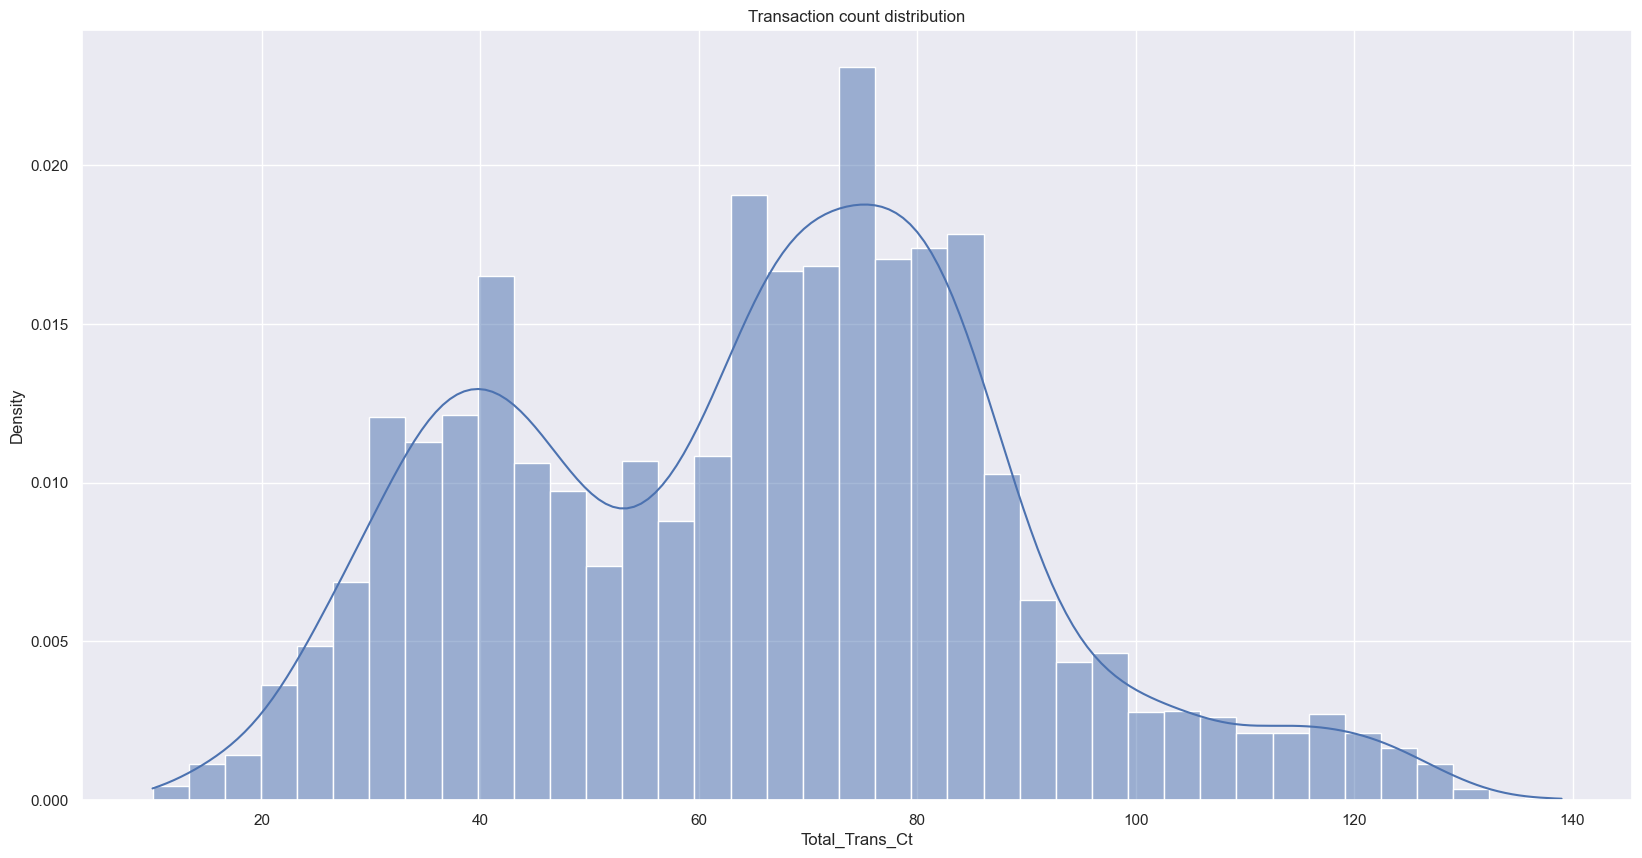

In [10]:
#Total_Trans_Ct distribution
plt.figure(figsize=(20,10)) 
sns.histplot(df['Total_Trans_Ct'], stat='density', kde=True);
plt.title('Transaction count distribution');

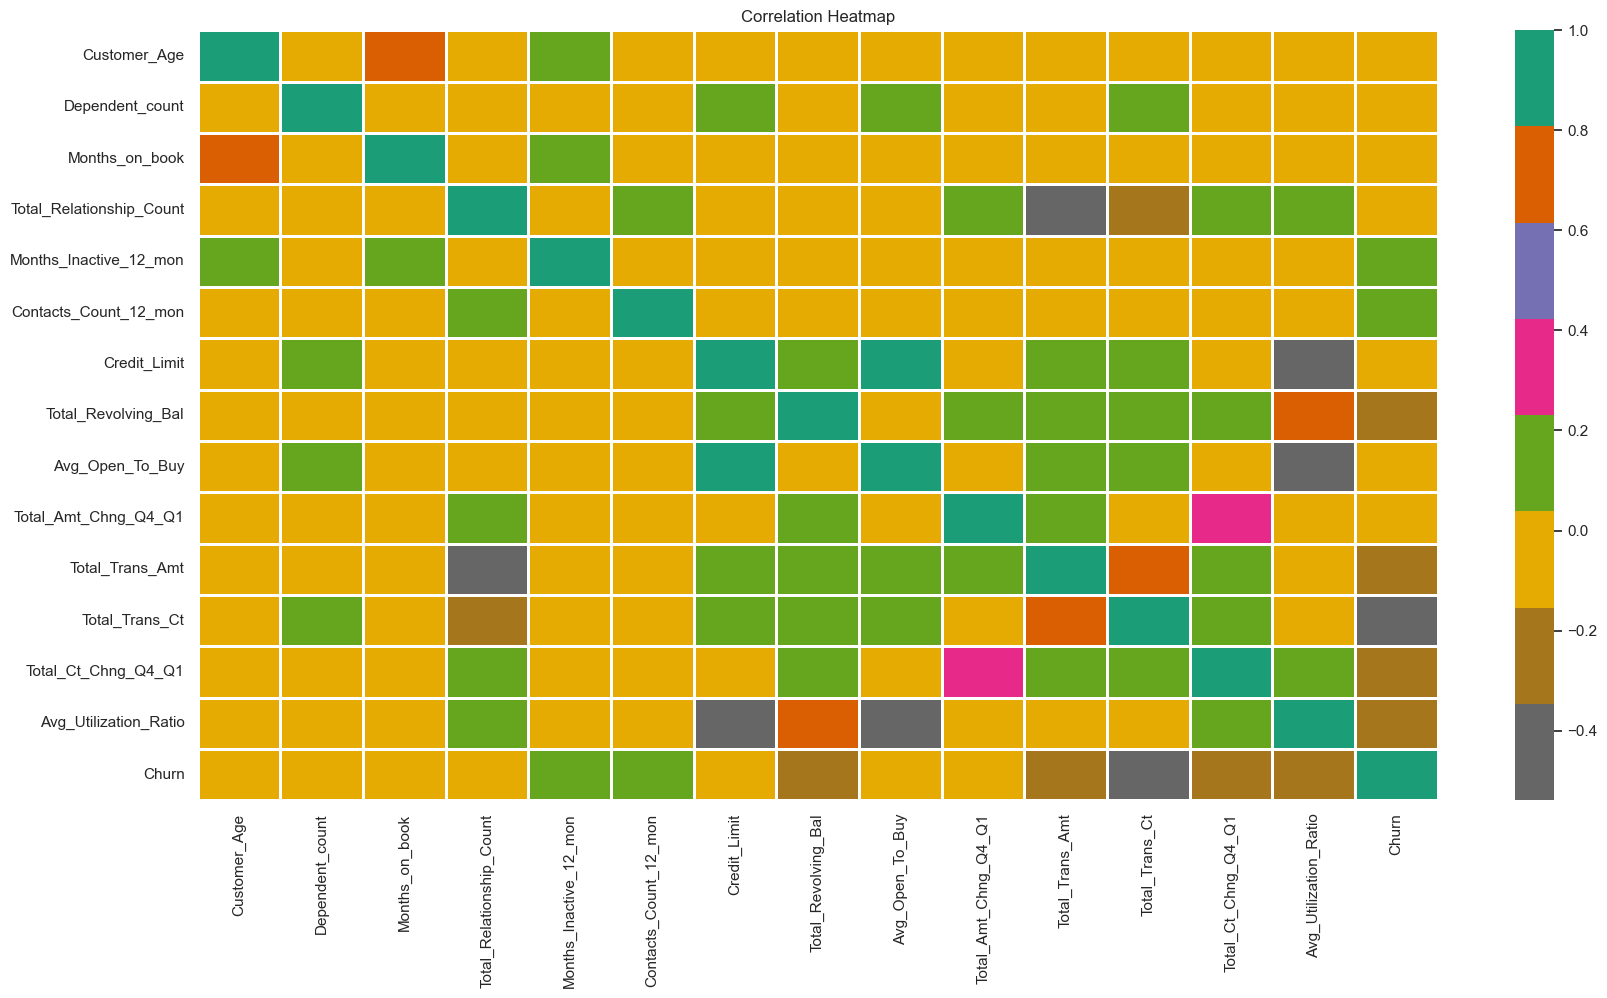

In [11]:
#correlation map
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), annot=False, cmap='Dark2_r', linewidths = 2)
plt.title('Correlation Heatmap');
plt.show()

### Feature Engineering

In [12]:
#target variable
y = df['Churn']

In [13]:
#predictor variables
X = df.drop(["Churn"], axis=1)

#one-hot encoding of categorical variables
X = pd.get_dummies(X, drop_first=True) 

In [14]:
X.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,...,0,0,0,1,0,0,0,0,0,0
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,...,1,0,0,0,0,1,0,0,0,0
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,...,0,0,0,0,1,0,0,0,0,0
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,...,0,1,0,0,0,1,0,0,0,0
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,...,0,0,0,1,0,0,0,0,0,0


In [15]:
X.shape

(10127, 32)

### Modelling

In [16]:
# This cell may take up to 15-20 minutes to run

# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

# grid search for best model parameters
rfc = RandomForestClassifier(random_state=42)
# Use a different solver if the default 'lbfgs' fails to converge
# Reference: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

lrc = LogisticRegression(solver='lbfgs', max_iter=3000)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,100],
    'criterion' :['gini', 'entropy']
}

cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring = 'accuracy', cv=5)
cv_rfc.fit(X_train, y_train)

lrc.fit(X_train, y_train)

#making predictions
y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train)
y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test)

y_train_preds_lr = lrc.predict(X_train)
y_test_preds_lr = lrc.predict(X_test)

# model scores
print('random forest results')
print('test results')
print(classification_report(y_test, y_test_preds_rf))
print('train results')
print(classification_report(y_train, y_train_preds_rf))

print('logistic regression results')
print('test results')
print(classification_report(y_test, y_test_preds_lr))
print('train results')
print(classification_report(y_train, y_train_preds_lr))

random forest results
test results
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2543
           1       0.94      0.76      0.84       496

    accuracy                           0.95      3039
   macro avg       0.95      0.87      0.91      3039
weighted avg       0.95      0.95      0.95      3039

train results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5957
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      7088
   macro avg       1.00      1.00      1.00      7088
weighted avg       1.00      1.00      1.00      7088

logistic regression results
test results
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2543
           1       0.72      0.47      0.57       496

    accuracy                           0.88      3039
   macro avg       0.81      0.72     

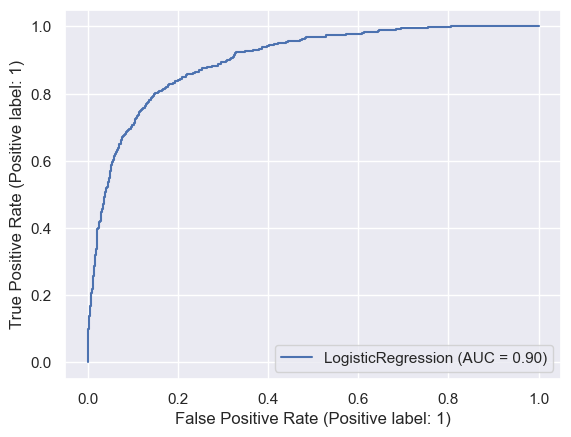

In [17]:
#ROC curve for LR model
lrc_plot = plot_roc_curve(lrc, X_test, y_test)

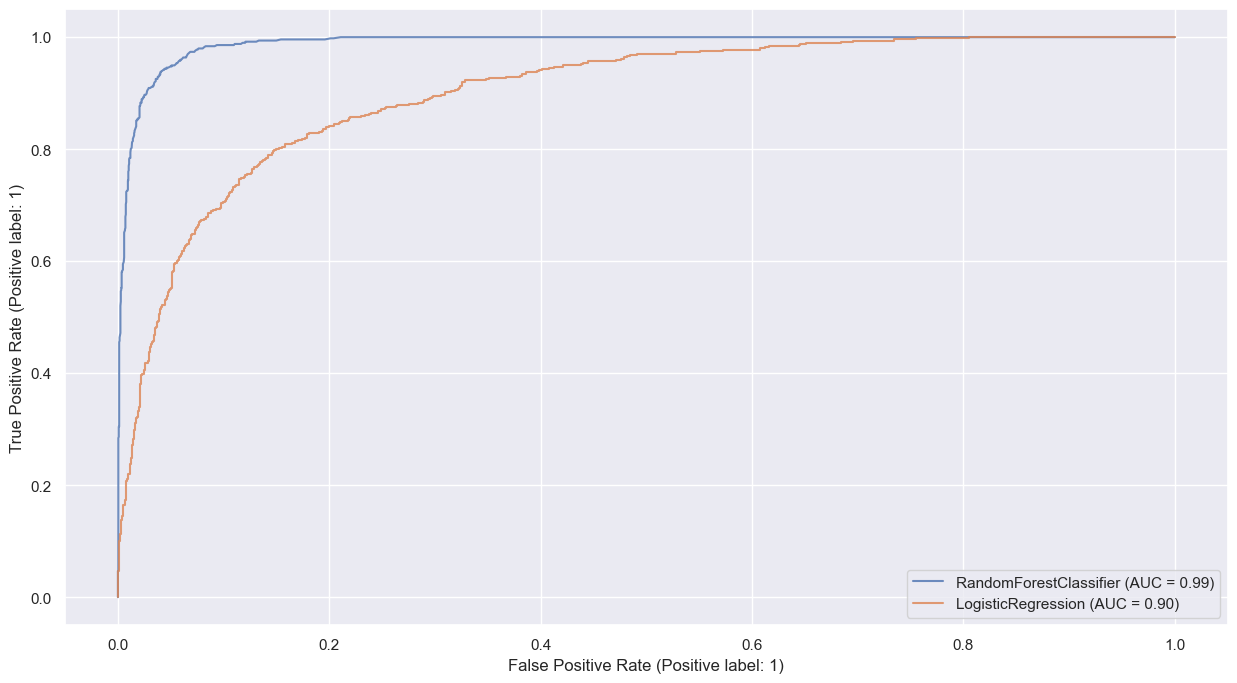

In [18]:
#ROC curve for LR and RF models
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

In [19]:
# saving best model
joblib.dump(cv_rfc.best_estimator_, './models/rfc_model.pkl')
joblib.dump(lrc, './models/lrc_model.pkl')

['./models/lrc_model.pkl']

In [20]:
#loading saved model
rfc_model = joblib.load('./models/rfc_model.pkl')
lr_model = joblib.load('./models/lrc_model.pkl')

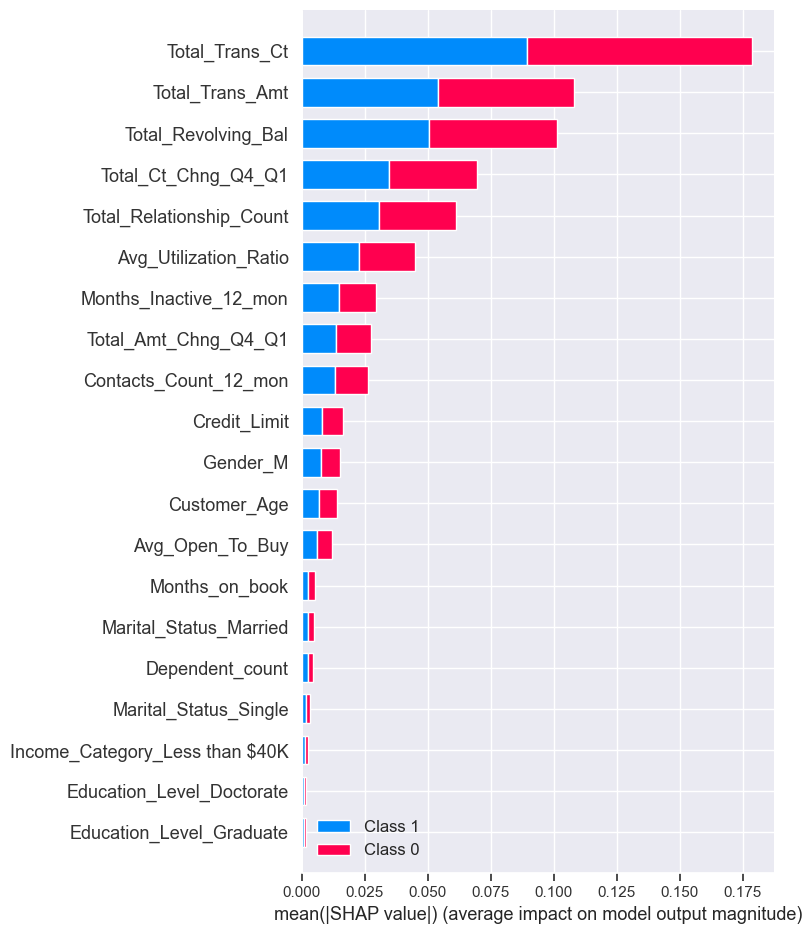

In [21]:
#RF tree explainer
explainer = shap.TreeExplainer(cv_rfc.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

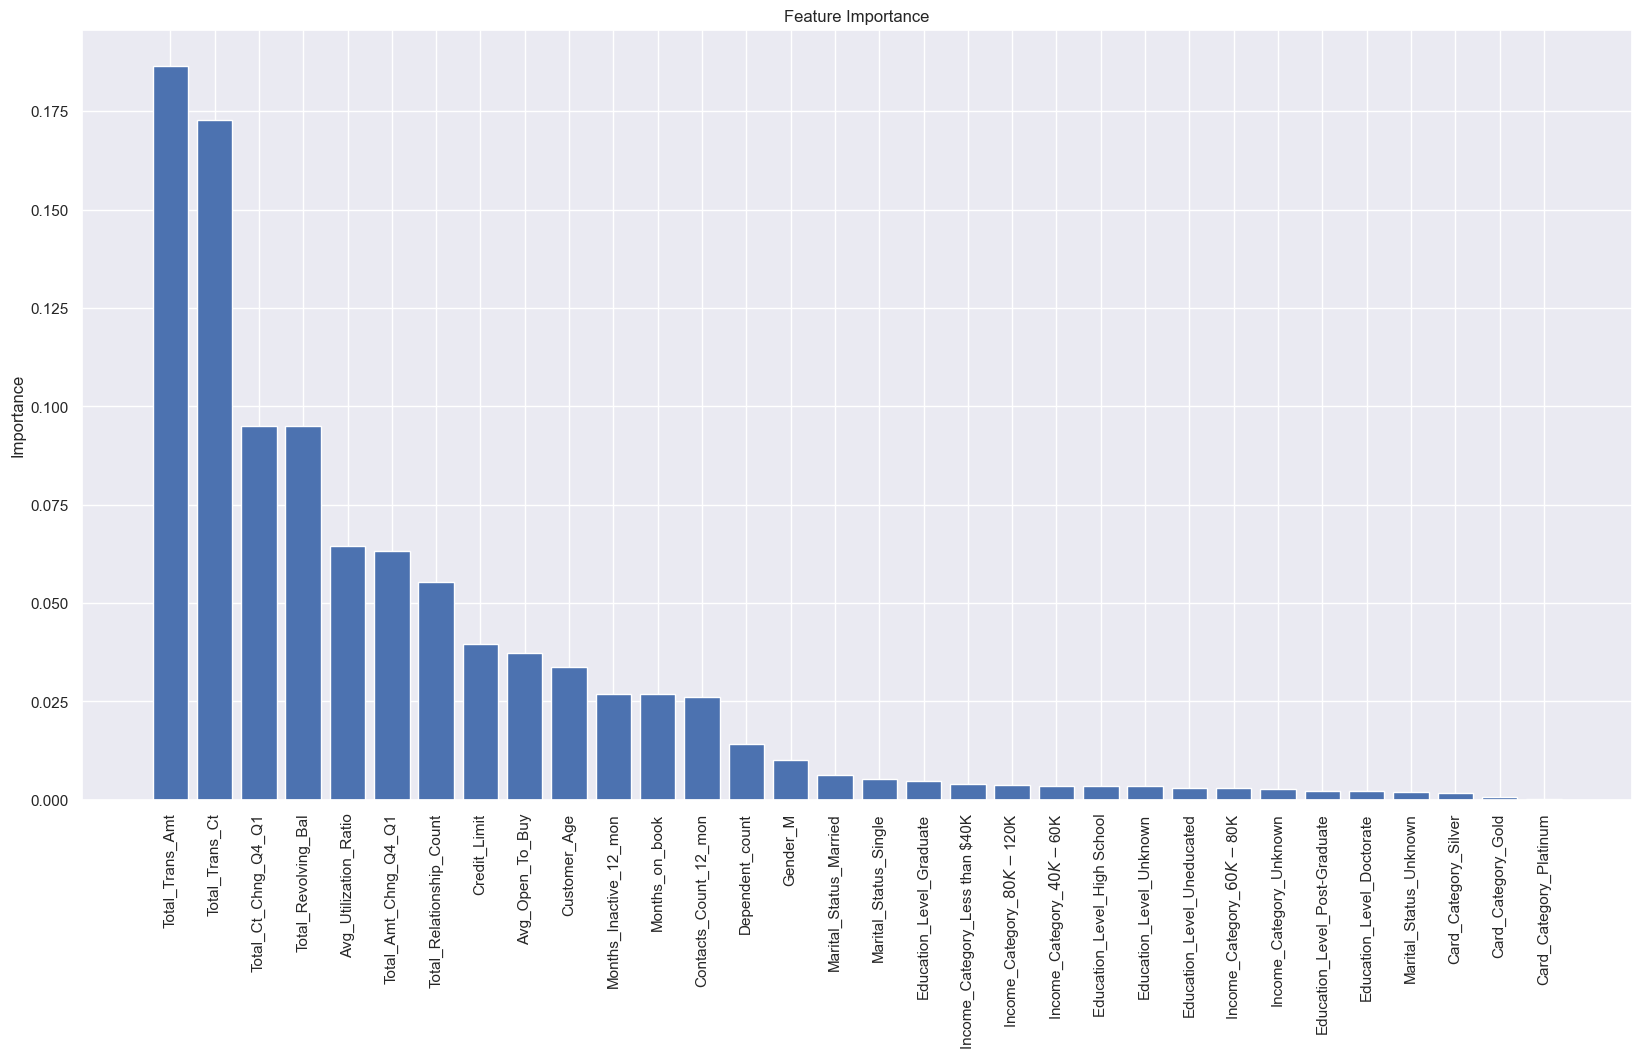

In [22]:
# Calculate feature importances
importances = cv_rfc.best_estimator_.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,10))

# Create plot title
plt.title("Feature Importance")
plt.ylabel('Importance')

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90);

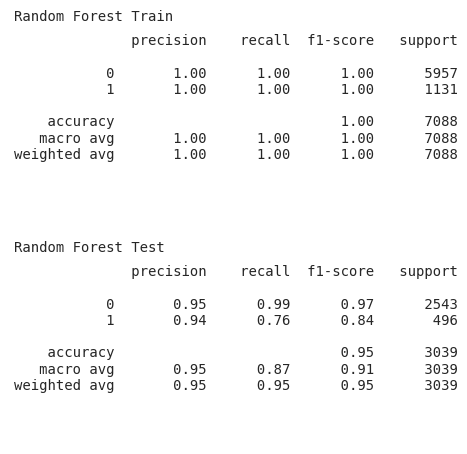

In [23]:
#RF Classification report
plt.rc('figure', figsize=(5, 5))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 1.1, str('Random Forest Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.5, str('Random Forest Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.1, str(classification_report(y_test, y_test_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');


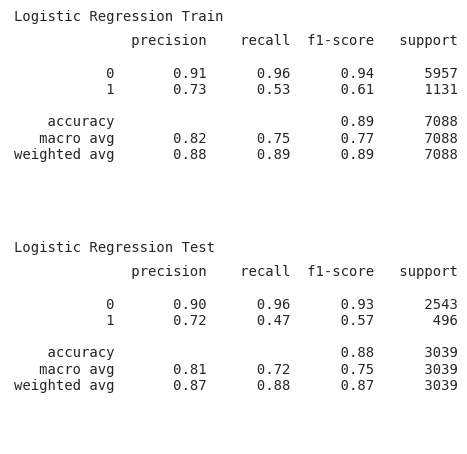

In [24]:
#LR Classification report
plt.rc('figure', figsize=(5, 5))
plt.text(0.01, 1.1, str('Logistic Regression Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.5, str('Logistic Regression Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.1, str(classification_report(y_test, y_test_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');